In [106]:
import os
import json

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style("darkgrid")

import pandas as pd
import numpy as np

# Loading data and preprocessing

In [4]:
%%time
df = pd.DataFrame.from_csv("./labeled.control.dump.csv")
df["time"] = pd.to_datetime(df.created_at)
df = df.set_index("time")

CPU times: user 2min 23s, sys: 929 ms, total: 2min 24s
Wall time: 2min 24s


### Exploring Time series

1. over a week
2. over a day
3. over the week days

Looking at day of week statistics

#### Preprocessing

here I'm just selecting the relevant data along with creating the appropriate columns

In [564]:
of_interest = (df.prediction_alcohol_svc > 0.75) & (df.prediction_firstperson_svc > 0.75)

In [565]:
df["first_person_alcohol"] = 0
df["first_person_alcohol"][of_interest] = 1
df["freq"] = 1

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [566]:
weekdays_index = ["M", "T", "W", "Th", "F", "S", "S"]

# First Level analysis

#### Day of week activity

We look at the probability distribution of a post being posted on a certain day given that a tweet is first person alcohol or not.

We make some obvious obserations such as the fact that 

In [567]:
def plot_groupby(gby, df=df, stat="mean", norm=True, newindex=None, yerr=True, **kwargs):
    temp = df.groupby(gby).agg({"first_person_alcohol":stat, "freq": "sum"})
    
    confidence = df.groupby(gby).agg({"first_person_alcohol":"std", "freq": "sum"})
    confidence.first_person_alcohol /= np.sqrt(confidence.freq)
    confidence.freq = 0
    
    if norm:   
        confidence.first_person_alcohol /= temp.first_person_alcohol.sum()
        confidence.freq /= temp.freq.sum()
        temp.first_person_alcohol /= temp.first_person_alcohol.sum()
        temp.freq /= temp.freq.sum()
         
    if newindex:
        temp.index = newindex
        
    if yerr:
        yerr = 1.96 * confidence
    else:
        yerr = None
    
    temp.plot(figsize=(16, 6), yerr=yerr, **kwargs)
    return temp, confidence
    

# Day of Week Activity Ratios

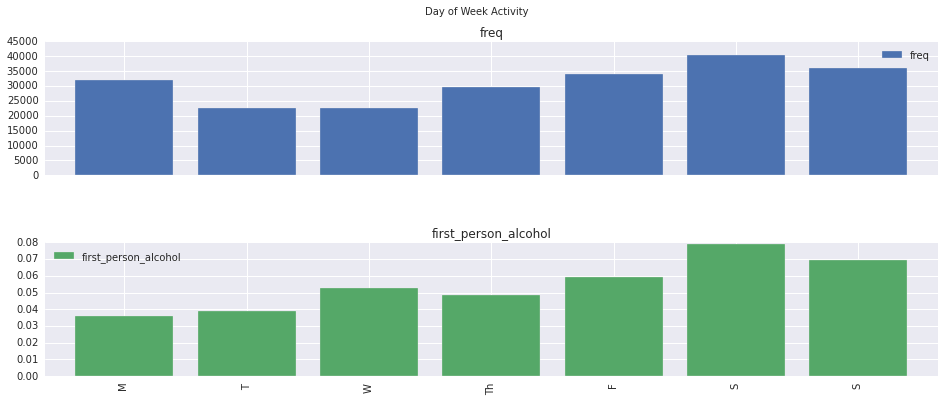

In [568]:
t, c = plot_groupby(
    gby=df.index.dayofweek,
    norm=0, subplots=1, layout=(2,1),
    newindex=weekdays_index,
    title="Day of Week Activity", kind="bar", width=.8)

# Hour Activity Ratios

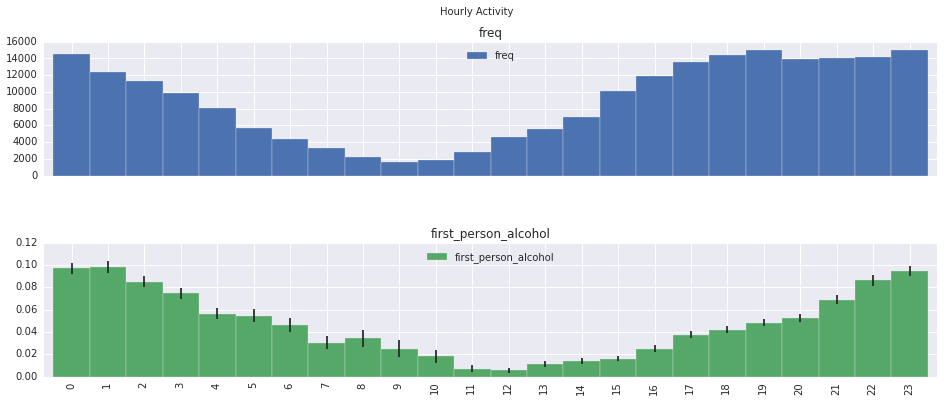

In [569]:
t, c = plot_groupby(
    [df.index.hour], stat="mean", norm=0, subplots=1, layout=(2, 1),
    title="Hourly Activity", kind="bar", width=1)

# Day of week & Hour Activity Ratios

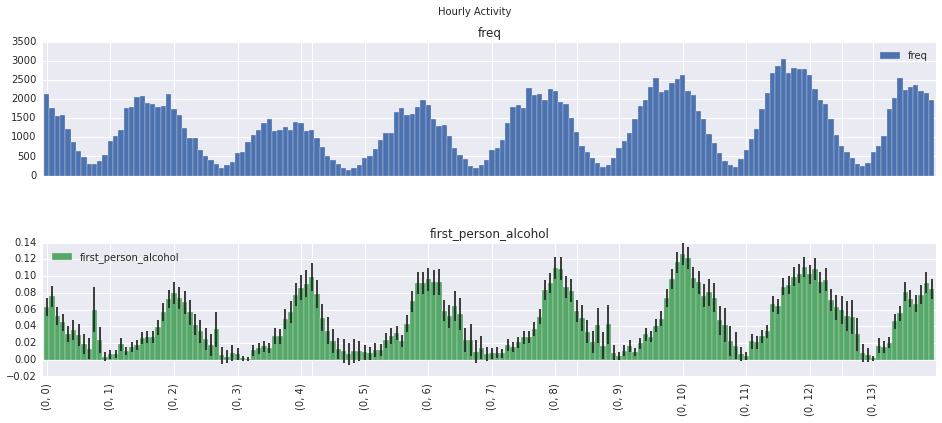

In [570]:
t, c = plot_groupby(
    [df.index.dayofweek, df.index.hour], stat="mean", 
    norm=0, subplots=1, layout=(2, 1), xticks=[_ for _ in range(24*7) if _%12==0],
    title="Hourly Activity", kind="bar", width=1)

# Second Level Analysis

In [571]:
col = ["prediction_firstperson_level_0", "prediction_firstperson_level_2", "prediction_firstperson_level_3"]
new_fp_cols = ["casual", "looking", "reflecting"]
for new_name, old_name in zip(new_fp_cols, col):
    df[new_name] = df[old_name] * df.prediction_alcohol_svc * df.prediction_firstperson_svc

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [572]:
def plot_groupby_fp(gby, df=df, stat="mean", norm=True, newindex=None, yerr=True, **kwargs):
    
    temp = df[new_fp_cols].groupby(gby).agg({_:stat for _ in new_fp_cols})
    confidence = df.groupby(gby).agg({_:"std" for _ in new_fp_cols})
    freq = df.groupby(gby).agg({"freq":"sum"})
    
    for c in temp.columns:
        confidence[c] /= np.sqrt(freq.freq)
        if norm: 
            confidence[c] /= temp[c].sum()
            temp[c] /= temp[c].sum()
    
    if newindex:
        temp.index = newindex
        
    if yerr:
        yerr = 1.96 * confidence
    else:
        yerr = None
    
    temp.plot(figsize=(16, 6), yerr=yerr, **kwargs)
    return temp, confidence
    

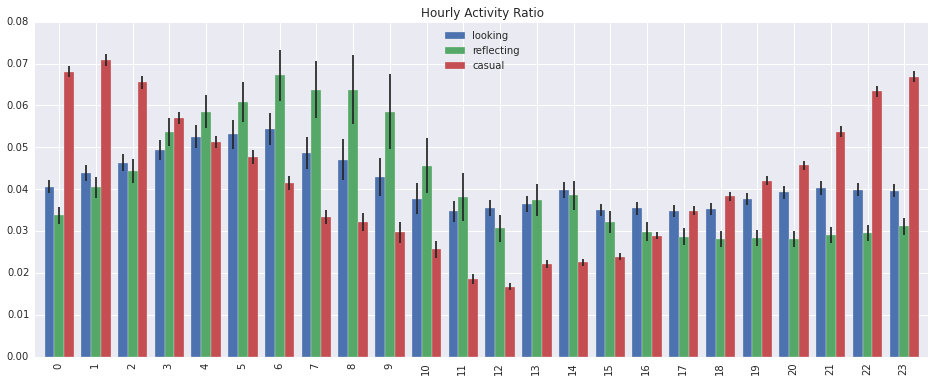

In [573]:
t, c = plot_groupby_fp(
    df.index.hour, norm=1, 
    title="Hourly Activity Ratio",
    kind="bar", width=0.8)

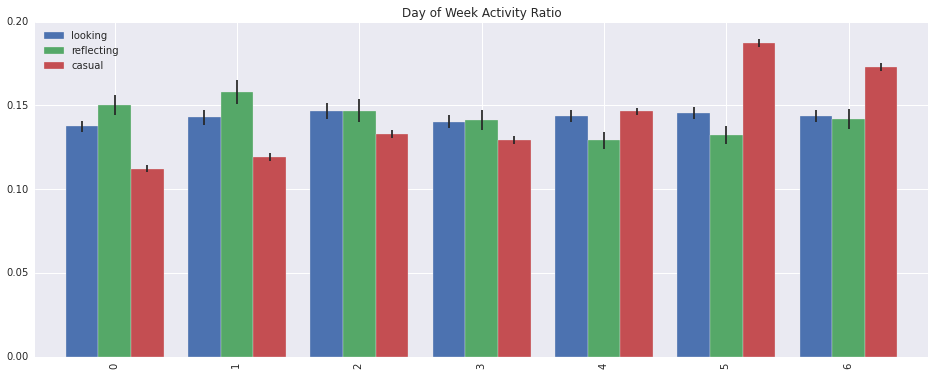

In [574]:
t, c = plot_groupby_fp(
    df.index.dayofweek, norm=1, 
    title="Day of Week Activity Ratio",
    kind="bar", width=0.8)

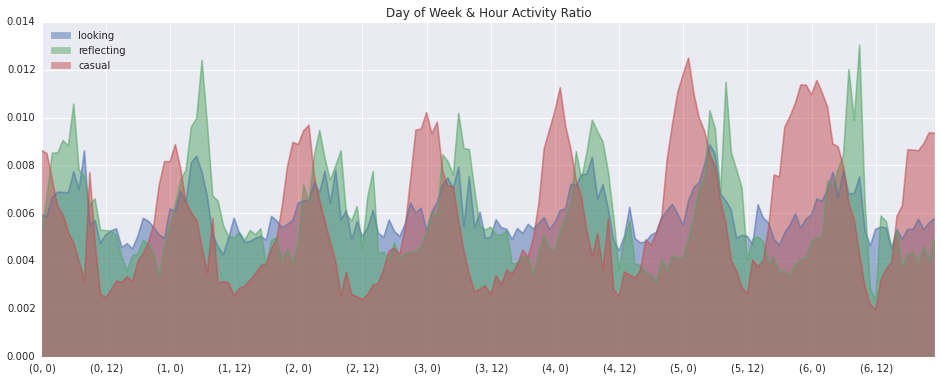

In [606]:
t, c = plot_groupby_fp(
    [df.index.dayofweek,df.index.hour], norm=1, 
    title="Day of Week & Hour Activity Ratio", xticks=[_ for _ in range(24*7) if _%12==0],
    kind="area", stacked=0, yerr=None)

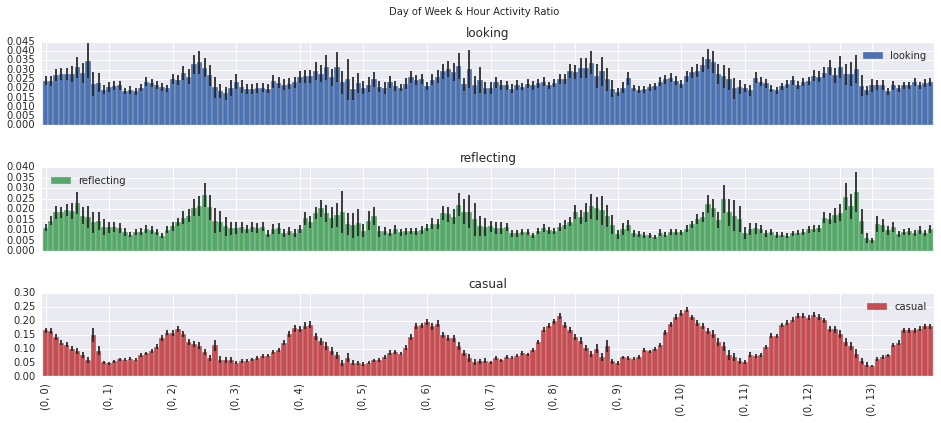

In [576]:
t, c = plot_groupby_fp(
    [df.index.dayofweek,df.index.hour], norm=0, 
    title="Day of Week & Hour Activity Ratio", xticks=[_ for _ in range(24*7) if _%12==0],
    kind="bar", subplots=1, width=1)

# Location Based Analysis

In [577]:
usa = df.place_fullname.str.contains("USA")

In [578]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

states_inverted = {v:k for (k,v) in states.items()}

In [579]:
def map2name(s):
    if "USA" in s:
        state = s[:-5]
        if state in states_inverted:
            return state
        else:
            return "<Other>"
    try:
        state_code = s[-2:]
        return states[state_code]
    except:
        return "<Other>"
    return "<Other>"

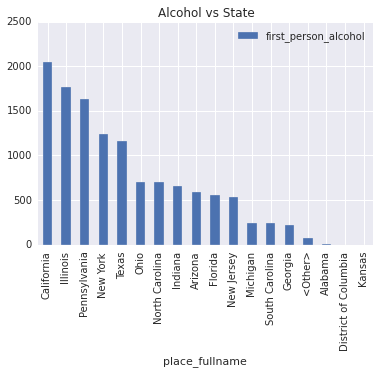

In [580]:
t = df.groupby(df.place_fullname.apply(map2name)).agg(
    {
        "first_person_alcohol": "sum"
    }
)

c = df.groupby(df.place_fullname.apply(map2name)).agg(
    {
        "first_person_alcohol": "std",
        "freq":"sum"
    }
)

err = c["first_person_alcohol"] / np.sqrt(c["freq"])
t.sort("first_person_alcohol", ascending=0).plot(kind="bar", title="Alcohol vs State", yerr=err)

## Comparing California to New York

In [581]:
df.state = df.place_fullname.apply(map2name)

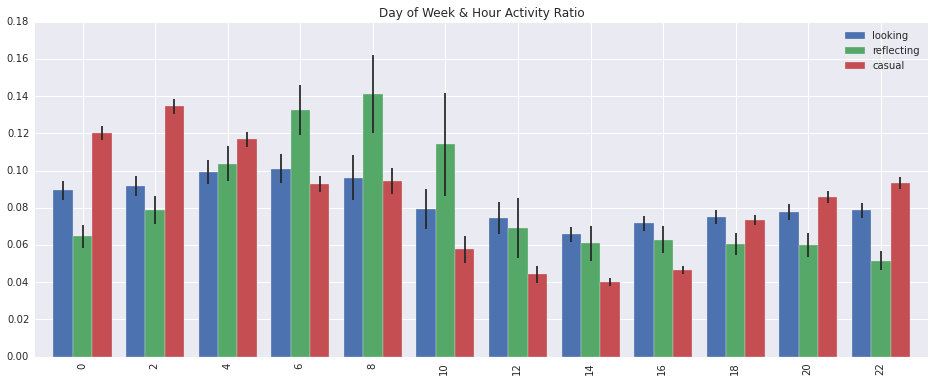

In [608]:
t_df = df[df.state == "California"]

t_california, c = plot_groupby_fp(
    [t_df.index.hour//2 * 2], df=t_df, norm=1, 
    title="Day of Week & Hour Activity Ratio",
    kind="bar", subplots=0, width=.8)

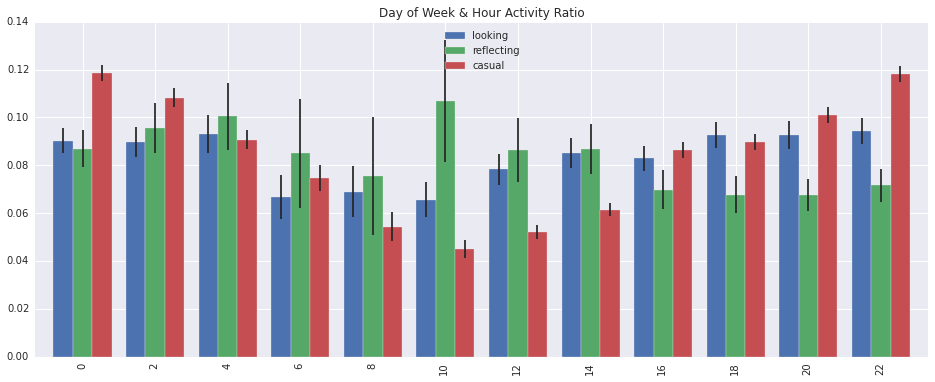

In [609]:
t_df = df[df.state == "New York"]

t_newyork, c = plot_groupby_fp(
    [t_df.index.hour // 2 * 2], df=t_df, norm=1, 
    title="Day of Week & Hour Activity Ratio",
    kind="bar", subplots=0, width=0.8)

In [601]:
t_california.columns = ["california_"+_ for _ in t_california.columns]
t_newyork.columns = ["newyork_"+_ for _ in t_newyork.columns]

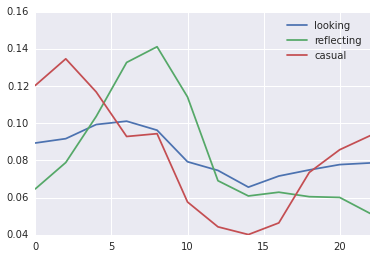

In [610]:
t_california.plot()

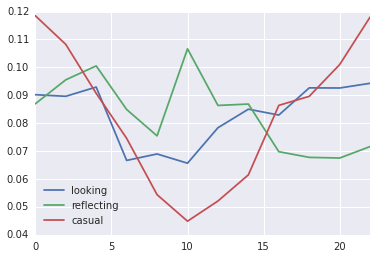

In [611]:
t_newyork.plot()

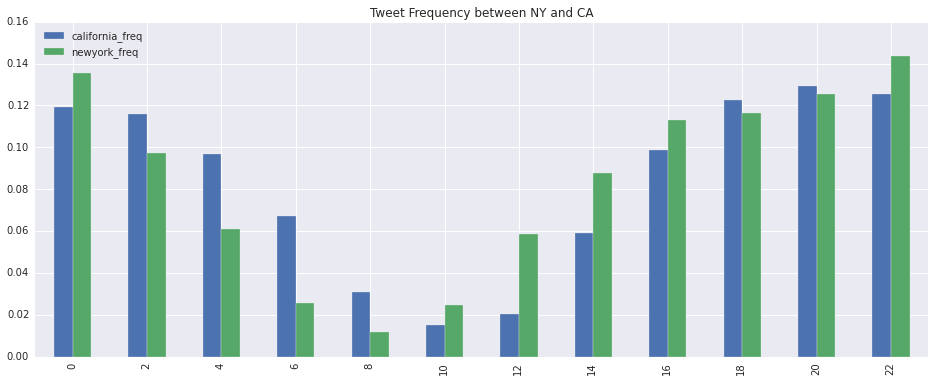

In [604]:
t_california.join(t_newyork)[[
    "california_freq",
    "newyork_freq",
]].plot(kind="bar", title="Tweet Frequency between NY and CA", figsize=(16, 6))

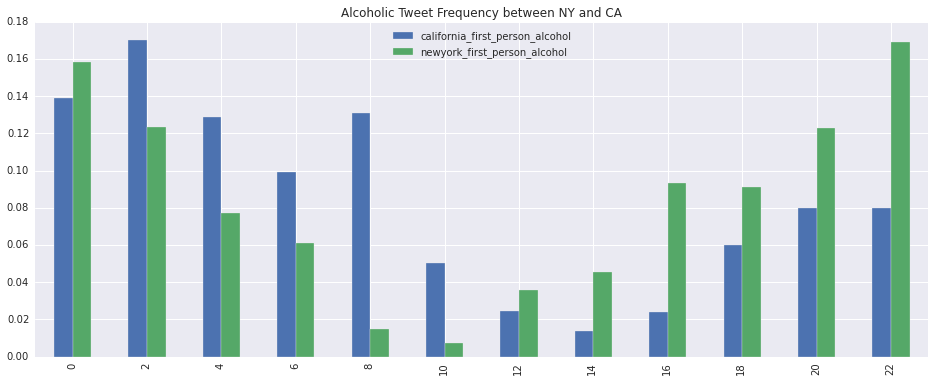

In [605]:
t_california.join(t_newyork)[[
    "california_first_person_alcohol",
    "newyork_first_person_alcohol",
]].plot(kind="bar", title="Alcoholic Tweet Frequency between NY and CA", figsize=(16, 6))

I personally think that this California First Person bump around 8am is weird... Is there a timezone problem?